In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
data = pd.read_csv("housing.csv")

In [355]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [356]:
data = data.dropna()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

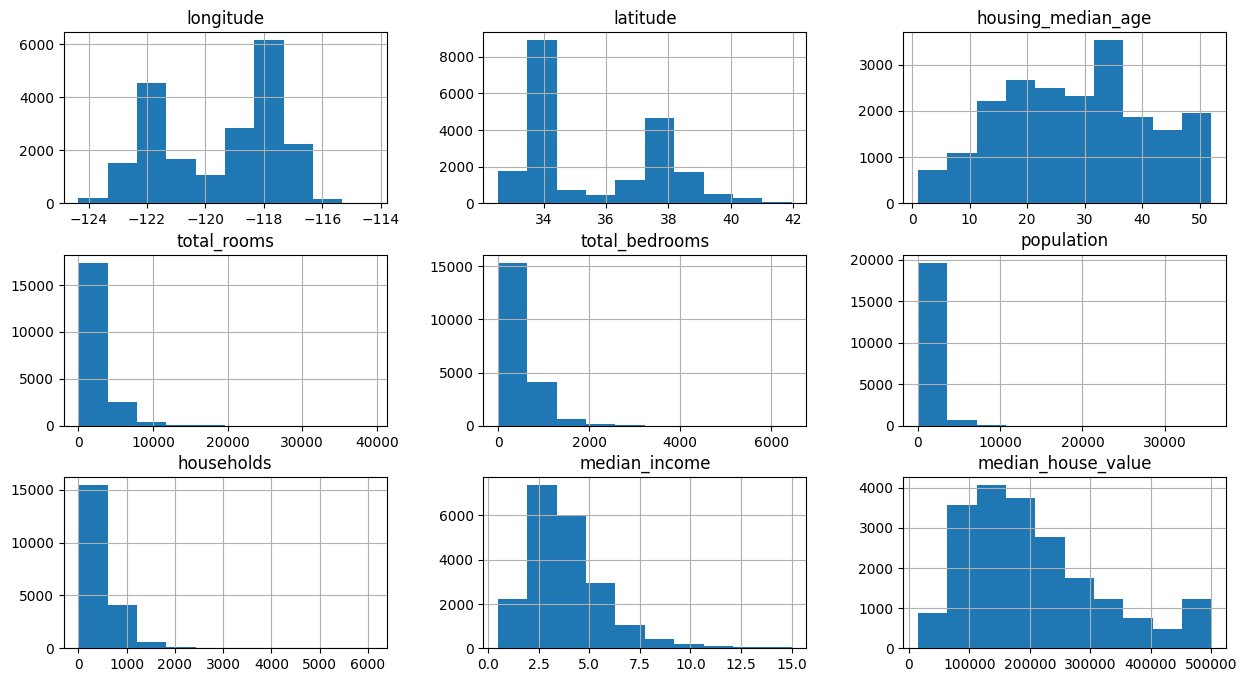

In [357]:
data.hist(figsize=(15, 8))

In [358]:
#Normalize some of the data
data['total_rooms'] = np.log(data['total_rooms'] + 1)
data['total_bedrooms'] = np.log(data['total_bedrooms'] + 1)
data['population'] = np.log(data['population'] + 1)
data['households'] = np.log(data['households'] + 1)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

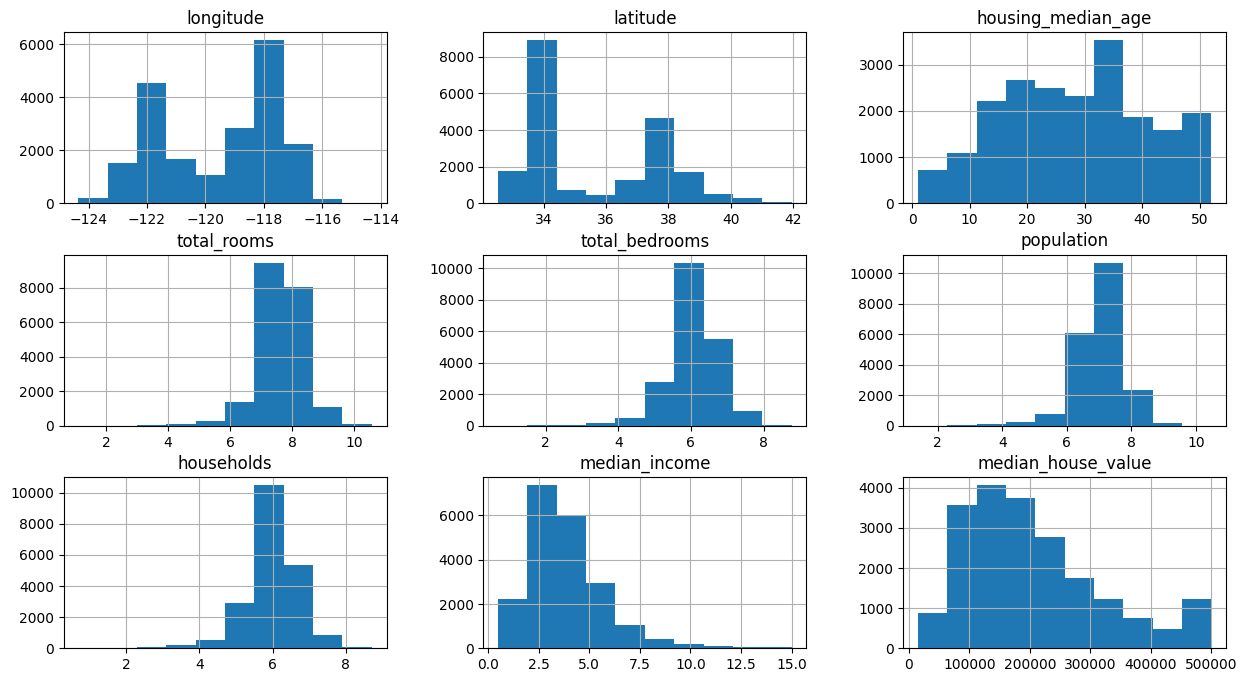

In [359]:
data.hist(figsize=(15, 8))

In [360]:
#One hot encode the ocean proximity column
data  = data.join(pd.get_dummies(data.ocean_proximity))

In [361]:
#Feature engineering
data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']
data['household_rooms'] = data['total_rooms'] / data['households']

<Axes: >

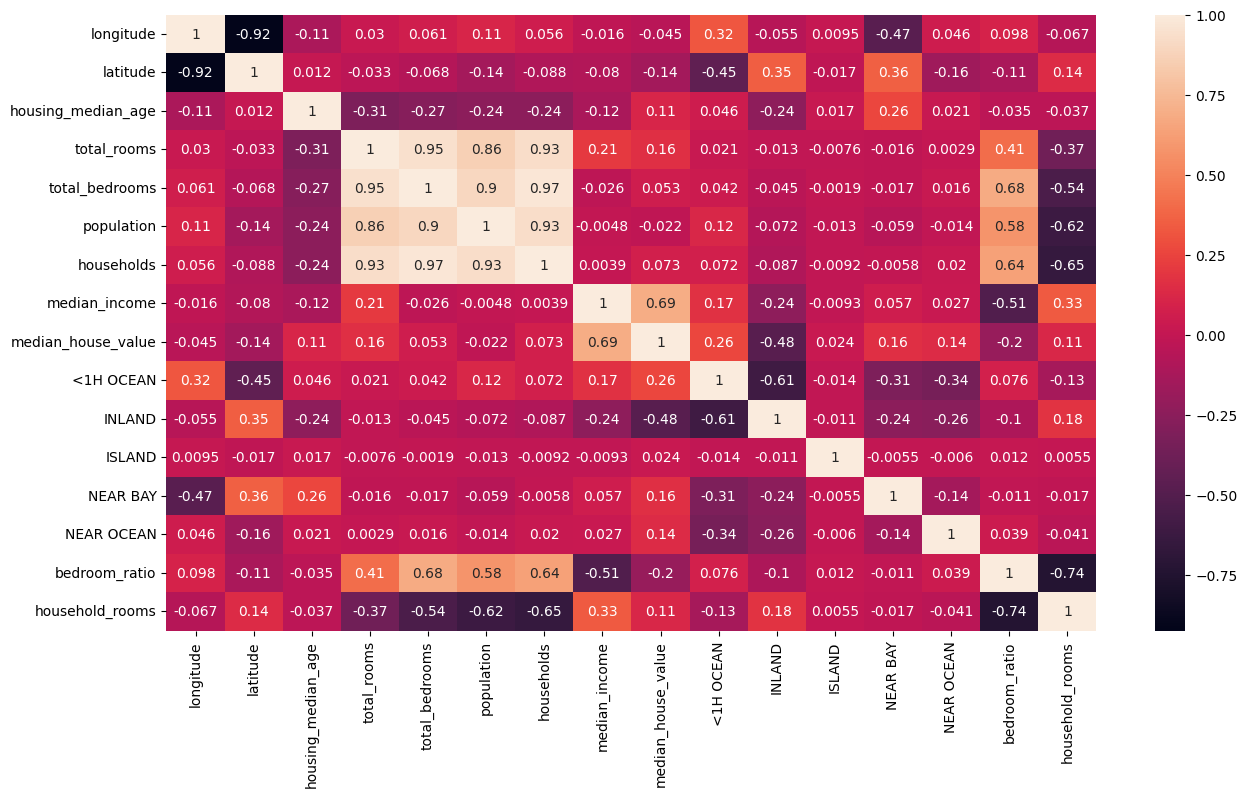

In [362]:
#Create a heatmap showing the correlation of each feature
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True)

In [363]:
from sklearn.model_selection import train_test_split


X = data.drop(['median_house_value'], axis = 1)
Y = data['median_house_value']

#Split the data into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=data['ocean_proximity'], random_state=42)

#Removing the ocean_proximity column
X_train = X_train.drop(['ocean_proximity'], axis = 1)
X_test = X_test.drop(['ocean_proximity'], axis = 1)

In [364]:
from sklearn.preprocessing import StandardScaler

#Scaling the data
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [365]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

#Create the linear regression model
linear_reg = LinearRegression()

#Trian the model
linear_reg.fit(X_train_s, Y_train)

#Test the model
Y_pred = linear_reg.predict(X_test_s)

#Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): 27.67%


In [366]:
from sklearn.ensemble import RandomForestRegressor

#Create the random forest regressor model
forest = RandomForestRegressor()

#Train the model
forest.fit(X_train_s, Y_train)

#Test the model
Y_pred = forest.predict(X_test_s)

# Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): 17.60%


In [367]:
from sklearn.metrics import r2_score
import xgboost as xgb

# Create the XGBoost regressor model
xgb_regressor = xgb.XGBRegressor()

# Train the model
xgb_regressor.fit(X_train_s, Y_train)

# Make predictions
Y_pred = xgb_regressor.predict(X_test_s)

# Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): 17.38%


In [368]:
import lightgbm as lgb

# Create the LightGBoost regressor model
lgb_regressor = lgb.LGBMRegressor()

# Train the model
lgb_regressor.fit(X_train_s, Y_train)

Y_pred = lgb_regressor.predict(X_test_s)

# Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 14
[LightGBM] [Info] Start training from score 207453.472654
Mean Absolute Percentage Error (MAPE): 17.66%


In [369]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 400, 450, 500],
    'num_leaves': [20, 70, 80, 90],
    'learning_rate': [0.01, 0.05, 0.04, 0.1, 0.3]
}
# Create the GridSearchCV object
grid_search_lgb = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid_lgb, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

# Perform grid search
grid_search_lgb.fit(X_train_s, Y_train)

# Evaluate the best model
best_lgb = grid_search_lgb.best_estimator_
best_lgb.score(X_test_s, Y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 13076, number of used features: 14
[LightGBM] [Info] Start training from score 206688.276155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 13077, number of used features: 14
[LightGBM] [Info] Start training from score 207752.138487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 13077, number of used features: 14
[LightGBM] [Info]

0.8583431726340032

In [370]:
Y_pred = best_lgb.predict(X_test_s)

# Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): 15.97%


In [371]:
from sklearn.ensemble import StackingRegressor


# Define the base models (use the models you've already trained)
base_models = [('XGBoost', xgb_regressor), ('LightGBM', best_lgb)]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking regressor
stacking_regressor.fit(X_train_s, Y_train)

# Make predictions
#Y_pred = stacking_regressor.predict(X_test_s)

# Evaluate the model
#score = r2_score(Y_test, Y_pred)
#print("R-squared score:", score)

Y_pred = stacking_regressor.predict(X_test_s)

# Calculate MAPE
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100  # Convert to percentage

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 14
[LightGBM] [Info] Start training from score 207453.472654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Number of data points in the train set: 13076, number of used features: 14
[LightGBM] [Info] Start training from score 206688.276155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 13077, number of used features: 14
[LightGBM] [Info]